In [1]:
using Distributed
addprocs(8);

In [2]:
using PulseInputDDM

In [3]:
ncells = [3,3];

In [4]:
ntrials = [400,400];

In [5]:
f = [["Softplus" for n in 1:N] for N in ncells]

2-element Vector{Vector{String}}:
 ["Softplus", "Softplus", "Softplus"]
 ["Softplus", "Softplus", "Softplus"]

In [6]:
n, cross = 53, false

(53, false)

In [7]:
θ_generative = θneural_choice(θz=θz(σ2_i = 5., B = 15., λ = -0.5, σ2_a = 100., σ2_s = 0.5,
    ϕ = 0.4, τ_ϕ = 0.02), bias=1.0, lapse=0.05, θy=[[Softplus(rand([-2., 2.])) for n in 1:N] for N in ncells], 
    f = f);

In [8]:
data, μ_rnt, μ_t = synthetic_data(θ_generative, ntrials, ncells; centered=true, pos_ramp=true, dt_synthetic=1e-4,
    rng=3);

In [91]:
output = pulse_input_DDM.process_spike_data.(μ_rnt, data; nconds=2);

In [92]:
μ_ct = getindex.(output, 1)
σ_ct = getindex.(output, 2);

In [93]:
model = neural_choiceDDM(θ_generative, data, n, cross)  

neural_choiceDDM{θneural_choice{θz{Float64},Float64,Array{Array{Softplus{Float64},1},1}},Array{Array{neuraldata,1},1}}
  θ: θneural_choice{θz{Float64},Float64,Array{Array{Softplus{Float64},1},1}}
  data: Array{Array{neuraldata,1}}((2,))
  n: Int64 53
  cross: Bool false


In [94]:
_, μ_c_λ, = simulate_expected_firing_rate(model; num_samples=100, nconds=2);

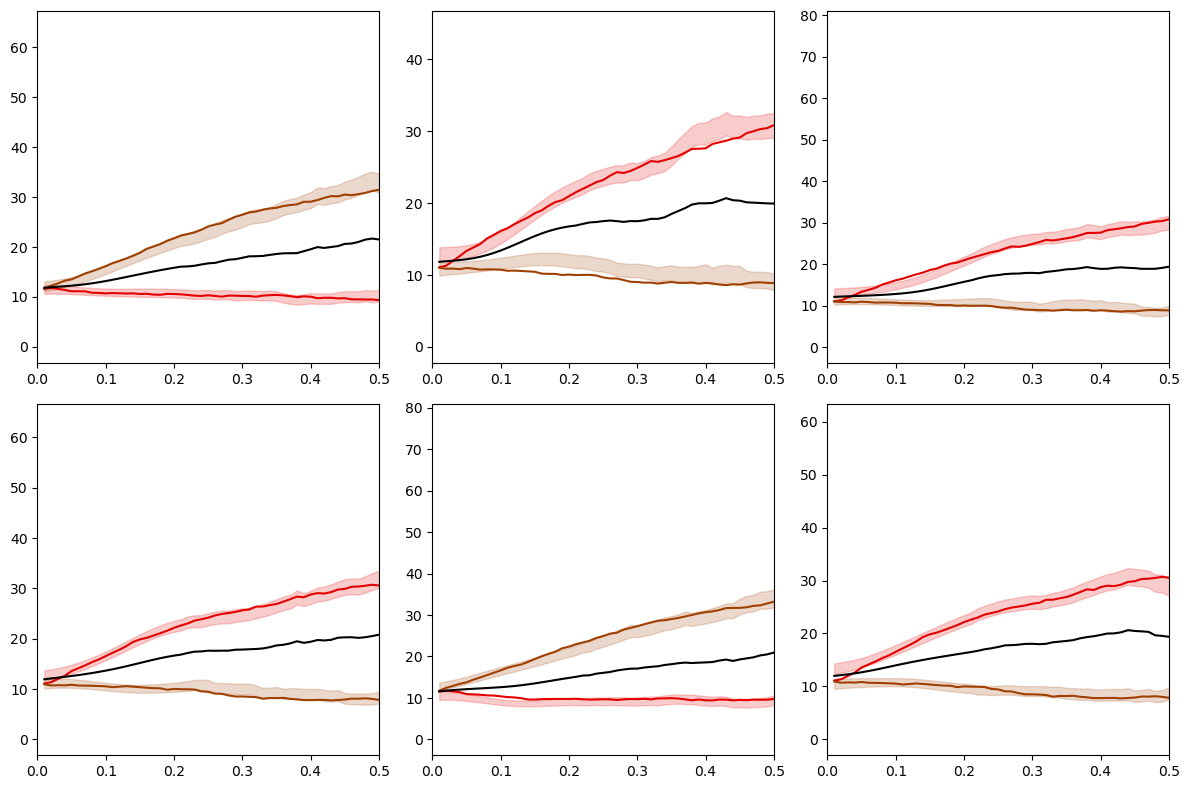

In [95]:
using PyPlot

dt = 1e-2

num_rows, num_cols = length(data), maximum(map(x-> x[1].ncells, data))
fig, ax = subplots(num_rows, num_cols, figsize=(4*maximum(map(x-> x[1].ncells, data)), 4*length(data)))
my_colors = ["#E50000","#9F3F00","#5A7F00","#15BF00"]

for i in 1:num_rows
        
    for j in 1:data[i][1].ncells             
        for k = 1:2     

            ax[i,j].fill_between((1:length(μ_ct[i][j][k]))*dt,
                μ_ct[i][j][k] + σ_ct[i][j][k],
                μ_ct[i][j][k] - σ_ct[i][j][k],
                alpha=0.2, color=my_colors[k])

            ax[i,j].plot((1:length(μ_c_λ[i][j][k]))*dt,
                μ_c_λ[i][j][k], color=my_colors[k])                                     

            ax[i,j].set_xlim((0, 0.5))
                        
        end   
        
        ax[i,j].plot((1:length(μ_t[i][j]))*dt,
            μ_t[i][j], color="black")

    end
    
end

tight_layout() 

In [96]:
options = neural_choice_options(f)
lb, ub, fit = options.lb, options.ub, options.fit
ub[2] = 40.
options = neural_choice_options(fit=fit, lb=lb, ub=ub);

In [97]:
using Flatten

In [98]:
joint_loglikelihood(model)

-64161.503616761656

In [127]:
x0 = vcat([0.1, 20., -0.1, 20., 0.8, 0.01, 0.008], 
    [0., 1e-1], vcat(θy.(data, f)...)...);

In [128]:
model = neural_choiceDDM(θneural_choice(x0, f), data, n, cross)  

neural_choiceDDM{θneural_choice{θz{Float64},Float64,Array{Array{Softplus{Float64},1},1}},Array{Array{neuraldata,1},1}}
  θ: θneural_choice{θz{Float64},Float64,Array{Array{Softplus{Float64},1},1}}
  data: Array{Array{neuraldata,1}}((2,))
  n: Int64 53
  cross: Bool false


In [129]:
joint_loglikelihood(model)

-66389.11929329159

In [130]:
model, = choice_neural_optimize(model, options; iterations=100, outer_iterations=10, f_tol=1e-12, x_tol=1e-12)

Fminbox
-------
Initial mu = 0.122727

Fminbox iteration 1
-------------------
Calling inner optimizer with mu = 0.122727

(numbers below include barrier contribution)
Iter     Function value   Gradient norm 
     0     6.638404e+04     5.024877e+04
 * time: 0.00014090538024902344
    10     6.445047e+04     2.210939e+04
 * time: 97.44564986228943
    20     6.427438e+04     2.557988e+03
 * time: 180.7646188735962
    30     6.419563e+04     1.609592e+03
 * time: 287.85887598991394
    40     6.417560e+04     1.164129e+02
 * time: 405.51329278945923
    50     6.416696e+04     1.689570e+03
 * time: 494.96301889419556
    60     6.415170e+04     7.271987e+02
 * time: 575.93434882164
    70     6.414991e+04     2.298237e+02
 * time: 649.2269458770752
    80     6.414977e+04     5.343601e+00
 * time: 736.8833649158478
    90     6.414976e+04     3.595596e-01
 * time: 817.8799068927765

Exiting inner optimizer with x = [6.329554431812653, 14.845373486613463, -0.6607807002547673, 126.289119

(neural_choiceDDM{θneural_choice{θz{Float64},Float64,Array{Array{Softplus{Float64},1},1}},Array{Array{neuraldata,1},1}}
  θ: θneural_choice{θz{Float64},Float64,Array{Array{Softplus{Float64},1},1}}
  data: Array{Array{neuraldata,1}}((2,))
  n: Int64 53
  cross: Bool false
,  * Status: success

 * Candidate solution
    Minimizer: [6.18e+00, 1.48e+01, -6.66e-01,  ...]
    Minimum:   6.415581e+04

 * Found with
    Algorithm:     Fminbox with BFGS
    Initial Point: [1.00e-01, 2.00e+01, -1.00e-01,  ...]

 * Convergence measures
    |x - x'|               = 8.82e-07 ≰ 1.0e-12
    |x - x'|/|x'|          = 6.78e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.04e-09 ≰ 1.0e-12
    |f(x) - f(x')|/|f(x')| = 1.62e-14 ≰ 0.0e+00
    |g(x)|                 = 1.28e-03 ≰ 1.0e-03

 * Work counters
    Seconds run:   1269  (vs limit 170000)
    Iterations:    3
    f(x) calls:    1172
    ∇f(x) calls:   346
)

In [131]:
hcat(collect(pulse_input_DDM.flatten(model.θ)), collect(pulse_input_DDM.flatten(θ_generative)))

15×2 Array{Float64,2}:
   6.1838       5.0
  14.7537      15.0
  -0.665511    -0.5
 128.914      100.0
   0.108269     0.5
   0.409058     0.4
   0.0186037    0.02
   0.897007     1.0
   0.0615143    0.05
   1.97631      2.0
  -1.99807     -2.0
  -1.93407     -2.0
  -1.90403     -2.0
   2.05473      2.0
  -1.94116     -2.0

In [132]:
_, μ_c_λ, = simulate_expected_firing_rate(model; num_samples=100, nconds=2);

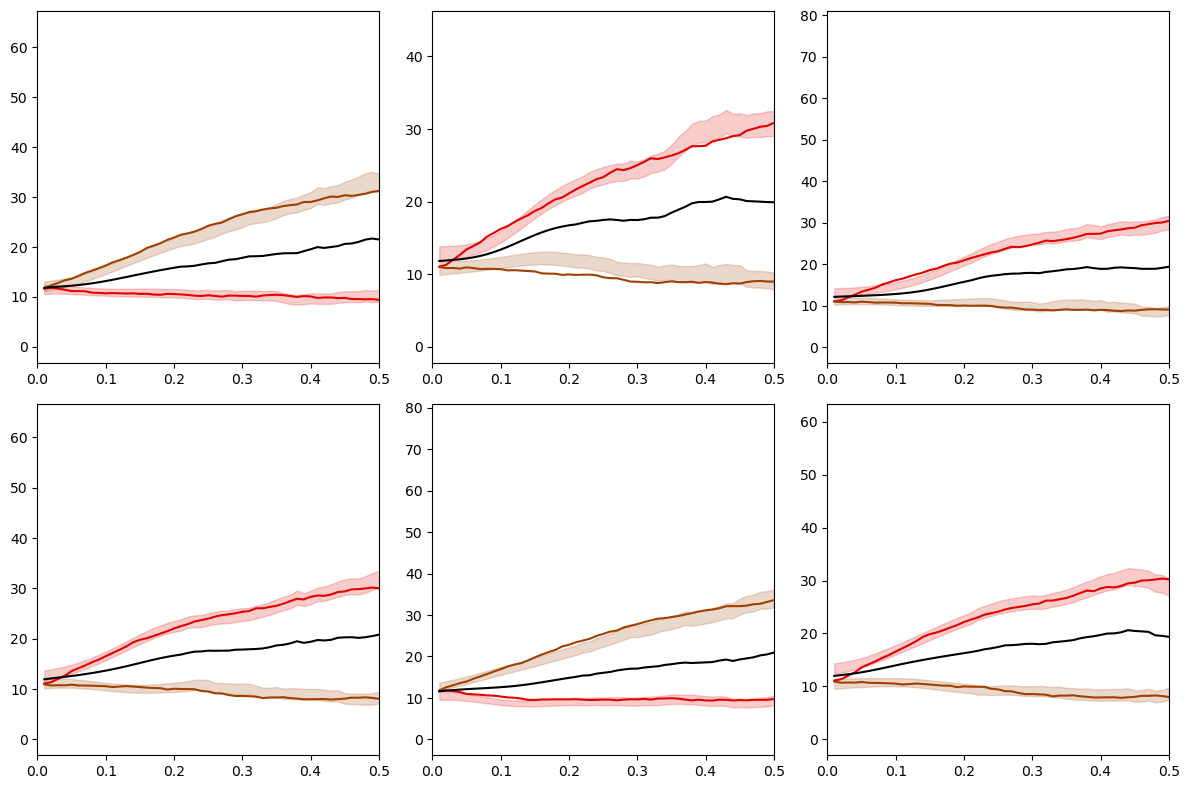

In [133]:
num_rows, num_cols = length(data), maximum(map(x-> x[1].ncells, data))
fig, ax = subplots(num_rows, num_cols, figsize=(4*maximum(map(x-> x[1].ncells, data)), 4*length(data)))
my_colors = ["#E50000","#9F3F00","#5A7F00","#15BF00"]

for i in 1:num_rows
        
    for j in 1:data[i][1].ncells             
        for k = 1:2     

            ax[i,j].fill_between((1:length(μ_ct[i][j][k]))*dt,
                μ_ct[i][j][k] + σ_ct[i][j][k],
                μ_ct[i][j][k] - σ_ct[i][j][k],
                alpha=0.2, color=my_colors[k])

            ax[i,j].plot((1:length(μ_c_λ[i][j][k]))*dt,
                μ_c_λ[i][j][k], color=my_colors[k])                                     

            ax[i,j].set_xlim((0, 0.5))
                        
        end   
        
        ax[i,j].plot((1:length(μ_t[i][j]))*dt,
            μ_t[i][j], color="black")

    end
    
end

tight_layout() 

In [134]:
H = Hessian(model)

15×15 Array{Float64,2}:
  0.994643     -0.0311275      1.81245   …      1.90207     -1.66343
 -0.0311275     8.39751       -6.62499          9.44909     -9.25359
  1.81245      -6.62499       68.1269          18.8142     -18.259
  0.0364321    -0.0476205      0.583231         0.330812    -0.413972
  1.1129       -1.5896        23.4615          13.8315     -16.7376
 -0.806792     -4.40201      100.73      …     52.4408     -47.6491
 22.2874      147.7        -3277.12         -1706.84      1652.71
 -0.00934016   -0.0642494     -0.243606        -0.755213    -1.21845
 -0.238085      0.265363     -10.8138           7.14692      0.948069
  1.89676      11.1148        18.2502          -0.0         -0.0
 -1.50857      -7.19872      -15.4152    …     -0.0         -0.0
 -1.74925      -6.95624      -17.0466          -0.0         -0.0
 -1.78342      -9.08635      -18.7076          66.9752     -86.2618
  1.90207       9.44909       18.8142         279.115       67.1638
 -1.66343      -9.25359      

In [135]:
using LinearAlgebra

In [138]:
eigvals(H)

15-element Array{Float64,1}:
      0.0013136951850186498
      0.37580556300991147
      1.7569247330901057
      9.45303000460432
     15.725157910597423
     45.931512166865055
     57.08080564460946
    152.9137551099866
    171.54398711091395
    354.77213258755825
    357.7347358156702
    368.9968183323559
    416.0190926130138
   4071.86685010588
 799707.2213571024

In [137]:
x = pulse_input_DDM.flatten(model.θ);

## Fix hessian if need be

In [101]:
@everywhere ℓℓ(x) = -joint_loglikelihood(x, model)

In [102]:
αs = 1e0 *collect(-0.2:0.01:0.2);

In [103]:
xs_neural = map(y-> x + y * eigvecs(H)[:,1], αs);
LL_steps_neural = map(y-> (!any((y .< lb) .| (y .> ub)) ? ℓℓ(y) : -Inf), xs_neural);

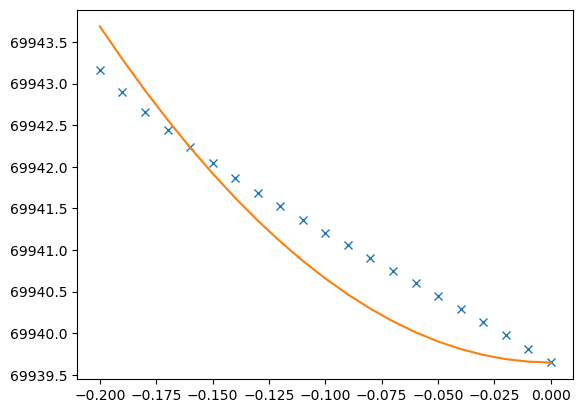

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f117a78fcf8>

In [104]:
finite_LL_steps_neural = filter(isfinite, LL_steps_neural);
finite_αs = αs[isfinite.(LL_steps_neural)];
β1 = (finite_αs.^2)\(finite_LL_steps_neural .- minimum(finite_LL_steps_neural))
plot(αs, LL_steps_neural, "x")
plot(finite_αs, β1 * finite_αs .^2 .+ minimum(finite_LL_steps_neural))

In [106]:
corrected_H = eigvecs(H) * Diagonal(vcat(2*β1, eigvals(H)[2:end])) * inv(eigvecs(H));

In [54]:
CI = 2 * sqrt.(diag(inv(corrected_H)))

LoadError: UndefVarError: corrected_H not defined

In [139]:
CI = 2 * sqrt.(diag(inv(H)))

15-element Array{Float64,1}:
  3.025967037401552
  2.7365947448439534
  0.39829858904579885
 55.134553364952374
  0.8594602592322308
  0.29631769477988357
  0.010512030628381144
  0.6709213850884505
  0.03144177221818806
  0.3643088609033955
  0.3699954166136129
  0.3575146852312564
  0.3511588495548098
  0.3804156780655482
  0.35874739972410175

In [140]:
hcat(collect(pulse_input_DDM.flatten(model.θ)) - CI, collect(pulse_input_DDM.flatten(θ_generative)), 
    collect(pulse_input_DDM.flatten(model.θ)) + CI)

15×3 Array{Float64,2}:
  3.15784       5.0     9.20977
 12.0171       15.0    17.4903
 -1.06381      -0.5    -0.267212
 73.7796      100.0   184.049
 -0.751191      0.5     0.967729
  0.11274       0.4     0.705376
  0.00809164    0.02    0.0291157
  0.226086      1.0     1.56793
  0.0300725     0.05    0.0929561
  1.612         2.0     2.34062
 -2.36806      -2.0    -1.62807
 -2.29159      -2.0    -1.57656
 -2.25519      -2.0    -1.55287
  1.67431       2.0     2.43514
 -2.29991      -2.0    -1.58241

In [141]:
hcat(collect(pulse_input_DDM.flatten(model.θ)) - CI .< 
    collect(pulse_input_DDM.flatten(θ_generative)) .< 
    collect(pulse_input_DDM.flatten(model.θ)) + CI)

15×1 BitArray{2}:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1

In [142]:
choice_inputs = map(x-> pulse_input_DDM.choiceinputs(clicks=x.clicks, binned_clicks=x.binned_clicks, 
    dt=1e-2, centered=false), getfield.(vcat(data...), :input_data));
choice_data = pulse_input_DDM.choicedata.(choice_inputs, getfield.(vcat(data...), :choice));
choices = getfield.(choice_data, :choice);

In [143]:
x

15-element Array{Float64,1}:
   6.183803359132311
  14.75373589359334
  -0.6655108706562605
 128.91413054567653
   0.10826884682887822
   0.40905818823807477
   0.018603674437860533
   0.8970070168763983
   0.06151431539682677
   1.9763110278293368
  -1.9980667444000586
  -1.9340707088106794
  -1.9040285994108221
   2.054727805688979
  -1.9411581388857622

In [144]:
syn_choices = rand.(Ref(Flatten.reconstruct(θchoice(), x[1:9])), choice_inputs, 1:length(choice_inputs));

In [145]:
output = map(x-> binLR(x.click_data.binned_clicks, x.click_data.clicks, x.click_data.dt), choice_data);
L,R = getindex.(output,1), getindex.(output,2);
ΔLR = last.(cumsum.(-L .+ R));

In [146]:
using Optim, LineSearches, ForwardDiff, Distributions
w0 = [0.1, 1., 0.];

In [147]:
mylogit(w) = (w[1]/2 .+ (1 .- w[1]) ./ (1. .+ exp.(-w[2]*ΔLR .+ w[3])));
ll(w) = -1 * sum(logpdf.(Bernoulli.(vec(mylogit(w))), choices))
obj = OnceDifferentiable(ll, w0; autodiff=:forward)
m = BFGS(alphaguess = InitialStatic(alpha=1.0,scaled=true), linesearch = BackTracking());
output = Optim.optimize(obj, [0, -Inf, -Inf], [1., Inf, Inf], w0, Fminbox(m));
what_data = Optim.minimizer(output);

In [148]:
xs = sort(ΔLR);
idxs = sortperm(ΔLR)
y_data = mylogit(what_data)[idxs];

In [149]:
ll(w) = -1 * sum(logpdf.(Bernoulli.(vec(mylogit(w))), syn_choices))
obj = OnceDifferentiable(ll, w0; autodiff=:forward)
output = Optim.optimize(obj, [0, -Inf, -Inf], [1., Inf, Inf], w0, Fminbox(m));
what_syn = Optim.minimizer(output);

In [150]:
y_syn = mylogit(what_syn)[idxs];

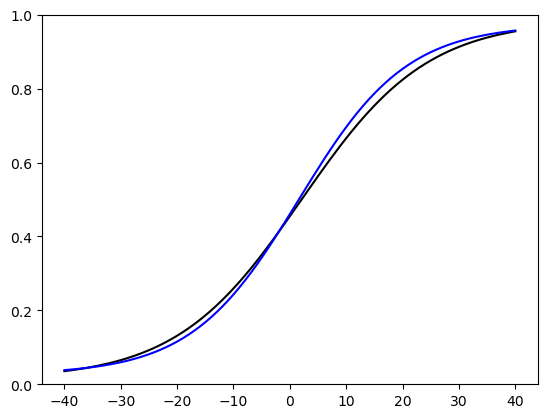

      From worker 2:	ErrorException("Process(2) - Invalid connection credentials sent by remote.")CapturedException(ErrorException("Process(2) - Invalid connection credentials sent by remote."), Any[(error(::String) at error.jl:33, 1), (process_hdr(::Sockets.TCPSocket, ::Bool) at process_messages.jl:273, 1), (message_handler_loop(::Sockets.TCPSocket, ::Sockets.TCPSocket, ::Bool) at process_messages.jl:167, 1), (process_tcp_streams(::Sockets.TCPSocket, ::Sockets.TCPSocket, ::Bool) at process_messages.jl:142, 1), ((::Distributed.var"#99#100"{Sockets.TCPSocket,Sockets.TCPSocket,Bool})() at task.jl:356, 1)])
      From worker 2:	Process(2) - Unknown remote, closing connection.
      From worker 5:	ErrorException("Process(5) - Invalid connection credentials sent by remote.")CapturedException(ErrorException("Process(5) - Invalid connection credentials sent by remote."), Any[(error(::String) at error.jl:33, 1), (process_hdr(::Sockets.TCPSocket, ::Bool) at process_messages.jl:273, 1), (message

      From worker 2:	ErrorException("Process(2) - Invalid connection credentials sent by remote.")CapturedException(ErrorException("Process(2) - Invalid connection credentials sent by remote."), Any[(error(::String) at error.jl:33, 1), (process_hdr(::Sockets.TCPSocket, ::Bool) at process_messages.jl:273, 1), (message_handler_loop(::Sockets.TCPSocket, ::Sockets.TCPSocket, ::Bool) at process_messages.jl:167, 1), (process_tcp_streams(::Sockets.TCPSocket, ::Sockets.TCPSocket, ::Bool) at process_messages.jl:142, 1), ((::Distributed.var"#99#100"{Sockets.TCPSocket,Sockets.TCPSocket,Bool})() at task.jl:356, 1)])
      From worker 2:	Process(2) - Unknown remote, closing connection.
      From worker 5:	ErrorException("Process(5) - Invalid connection credentials sent by remote.")CapturedException(ErrorException("Process(5) - Invalid connection credentials sent by remote."), Any[(error(::String) at error.jl:33, 1), (process_hdr(::Sockets.TCPSocket, ::Bool) at process_messages.jl:273, 1), (message

In [151]:
plot(xs, y_data, label="data", color="black", LineStyle="-")
plot(xs, y_syn, label="syn", color="blue", LineStyle="-")
ylim(0,1);